In [1]:
import numpy as np
import pylab
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

# Binary classifier for data drift

For drift detection between datasets A and B, one can set up a binary classifier, where the samples are the data samples from A or B, and the label is 0/1 depending on whether or not the sample came from dataset A/B.

A drift detection alert can then be raiased when the model starts being able to discern/classify between samples from the two datasets.

### Data drift example

As a play example, consider the first method on some data that drifts over days.

In [2]:
def get_binned_samples(loc: float, n_sample: int, bin_width: float=0.1, scale: float=1.0) -> dict[float, float]:
    """ loc - centre of normal distribution
        n_sample - number of samples to generate
        bin_width - width of the bins to make the histogram
        scale - standard deviation of normal distribution
        
        returns a dict<bin value, frequency of bin>
    """
    samples = np.random.normal(loc=loc, scale=scale, size=n_sample)
    binned_samples = {}
    for sample in samples:
        bin = int(sample / bin_width) * bin_width
        binned_samples[bin] = binned_samples.get(bin, 0) + 1
    if 0 in binned_samples.keys():
        binned_samples[0] /= 2  # overcounting of zero bin
    return binned_samples

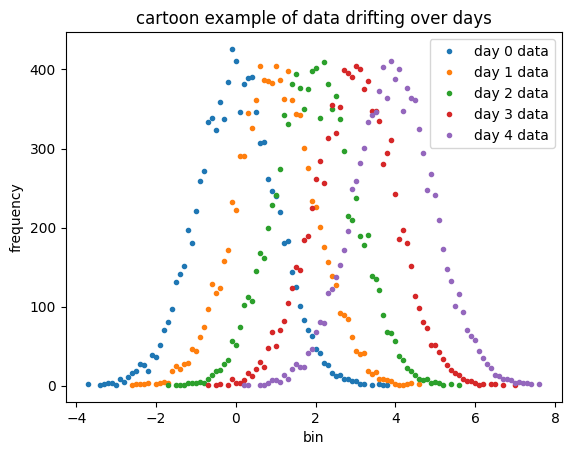

In [3]:
n_sample = 10000
dayN_datas = []
for i_day, loc in enumerate(np.arange(0,5,1.0)):
    this_samples = get_binned_samples(loc, n_sample)
    pylab.plot(this_samples.keys(), this_samples.values(), '.', label=f"day {i_day} data")
    dayN_datas.append(this_samples)
pylab.xlabel("bin")
pylab.ylabel("frequency")
pylab.title("cartoon example of data drifting over days")
_ = pylab.legend()

### Training and testing a binary classifier

One can get a training set of data by combining two datasets together, and label the samples by which dataset they came from. If there is no data drift, any binary classifier built on the data should not be able to discern between the two datasets. If there is data drift, one might expect the model to discern between the datasets.

In [4]:
n_sample = 10000
scale = 1.0

# get samples for the zeroth day
X0 = np.random.normal(loc=0, scale=scale, size=n_sample).reshape((n_sample, 1))
y0 = np.zeros(n_sample)
print(f"X0 shape = {X0.shape}, y0 shape = {y0.shape}")

X0 shape = (10000, 1), y0 shape = (10000,)


In [5]:
# get and test the drifted data by day
data = []
labels = []
cv_scoring = "f1"
n_cross_vals = 5
for i_day, loc in enumerate(np.arange(0,5,1.0)):
    # generate data for the drifted day
    X1 = np.random.normal(loc=loc, scale=scale, size=n_sample).reshape((n_sample, 1))
    y1 = np.zeros(n_sample) + 1
    # make a combined dataset of the zeroth day with current day, labelling the samples by day
    X = np.concatenate((X0, X1))
    y = np.concatenate((y0, y1))
    X, y = shuffle(X, y)
    clf = RandomForestClassifier()
    cv_scores = cross_val_score(clf, X, y, cv=n_cross_vals, scoring=cv_scoring)
    data.append(cv_scores)
    labels.append(f"day {i_day}")

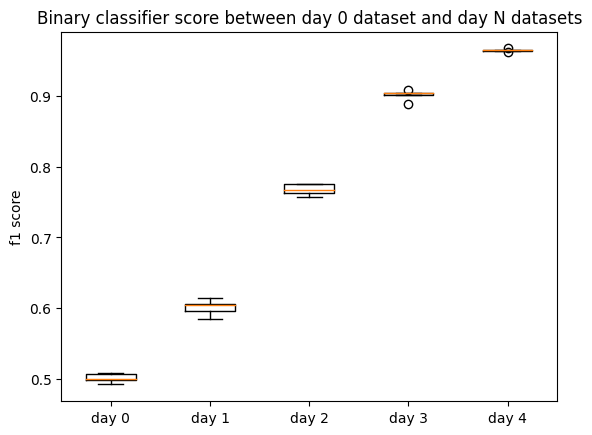

In [6]:
pylab.boxplot(data, labels=labels)
pylab.ylabel(f"{cv_scoring} score")
_ = pylab.title("Binary classifier score between day 0 dataset and day N datasets")

When there is no data drift, the F1 score is around 0.5, reflecting that the model cannot discern between the two datasets. As the drift becomes more apparent, the model performance increases.